# 量桨中的常用函数

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

此处我们列举量桨中常用的函数，对初学者来说已可以处理大多数问题。

其他量桨函数以及具体细节可见 [API](https://qml.baidu.com/api/introduction.html).

在本节末尾，给出制备量子纯态的量桨实现代码，介绍量桨实现量子神经网络算法的基本框架。

## 1. 加入模块

In [1]:
# 1.1 Numpy, Paddle
import numpy as np
import paddle

# 1.2 量子电路
from paddle_quantum.circuit import UAnsatz 

# 1.3 量子态 —— np.ndarray 形式
from paddle_quantum.state import vec, vec_random  # 向量
from paddle_quantum.state import density_op, density_op_random, completely_mixed_computational  # 矩阵

# 1.4 矩阵 —— np.ndarray 形式
from scipy.stats import unitary_group  # 随机 U 矩阵
from paddle_quantum.utils import pauli_str_to_matrix  # n 量子比特泡利矩阵

# 1.5 矩阵运算 —— paddle.Tensor 形式
from paddle import matmul, trace  # 计算內积与迹
from paddle_quantum.utils import dagger  # 对 paddle.Tensor 计算复共轭 (注：对 numpy.ndarray 通过“.conj().T”)

# 1.6 画图
import matplotlib.pyplot as plt

## 2. 常用参数

In [2]:
# 2.1 用于构造量子电路

N = 3      # 量子电路量子比特数
DEPTH = 2  # 量子电路深度 (层数)

In [3]:
# 2.2 迭代优化参数

ITR = 200  # 迭代次数 
LR = 0.2   # 学习速率 
SEED = 1   # 随机种子 
paddle.seed(SEED)     # paddle种子
np.random.seed(SEED)  # numpy种子

## 3. Numpy 矩阵相关

In [4]:
# 3.1 随机幺正矩阵
V = unitary_group.rvs(2)  # 随机 2*2 V

In [5]:
# 3.2 对角矩阵
D = np.diag([0.2, 0.8])

In [6]:
# 3.3 复共轭
V_dagger = V.conj().T

In [7]:
# 3.4 矩阵乘法：@
H = (V @ D @ V_dagger)

In [8]:
# 3.5 迹
H.trace()

(0.9999999999999998-8.239936510889834e-18j)

In [9]:
# 3.6 特征值
np.linalg.eigh(H)[0]

array([0.2, 0.8])

In [10]:
# 3.7 张量积： A \otimes B
A = np.eye(2)
B = H
T = np.kron(A, B)

- 注：在量桨中，可以通过字符串形式构建 $n$ 量子比特泡利矩阵。

In [11]:
# 例: 0.4*I⊗Z+0.4*Z⊗I+0.2*X⊗X
# 文字形式: 0.4*kron(I, Z) + 0.4*kron(Z, I) + 0.2*kron(X, X)
H_info = [[0.4, 'z0'], [0.4, 'z1'], [0.2, 'x0,x1']]
H_matrix = pauli_str_to_matrix(H_info, 3)  # 3 量子比特泡利矩阵

## 4. 量子态相关

In [12]:
# 4.1 得到纯态 (np.ndarray 形式的行向量)

initial_state_pure1 = vec(0, N)      # 得到 |00…0>, 2**N 维行向量
initial_state_pure2 = vec_random(N)  # 得到随机纯态，行向量

In [13]:
# 4.2 得到混态(np.ndarray 形式）

initial_state_mixed1 = density_op(N)  # 得到 |00…0><00…0|
initial_state_mixed2 = density_op_random(N, real_or_complex=2, rank=4)  # 得到随机密度矩阵，可选择为实数或复数，可选择秩
initial_state_mixed3 = completely_mixed_computational(N)  # 得到最大混态 

## 5. 量子电路相关

In [14]:
# 5.1 创建 N 量子比特电路
cir = UAnsatz(N)

In [15]:
# 5.2 添加量子门 —— 具体见第7节
# 例：添加CNOT门到前两个量子比特
cir.cnot([0, 1])

In [16]:
# 5.3 输出量子态
# 输出向量形式量子态（paddle.Tensor）。
# 注：此处输出态shape并不是向量，可通过paddle.reshape(final_state, [2**N, 1])转化为列向量 —— 在后续版本中将进一步优化。

# 初始态为 |00...0>
final_state = cir.run_state_vector()
# 初始态非 |00...0>
initial_state_pure = paddle.to_tensor(initial_state_pure2)
final_state_pure = cir.run_state_vector(initial_state_pure)
# 化为 numpy 列向量形式
final_state_pure_np = cir.run_state_vector().reshape([2**N, 1]).numpy()

In [17]:
# 初始态为 |00…0><00…0|
cir.run_density_matrix()
# 初始态非 |00...0><00…0|
initial_state_mixed = paddle.to_tensor(initial_state_mixed2)
final_state_mixed = cir.run_density_matrix(initial_state_mixed)
# 改变为 numpy 矩阵形式
final_state_mixed_np = cir.run_density_matrix().numpy()

In [18]:
# 5.4 量子电路对应幺正矩阵 (paddle.Tensor)
cir.U
# 改变为 numpy 矩阵形式
cir.U.numpy()
# 仅保留实数部分
cir.U.real()
cir.U.numpy().real

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]])

In [19]:
# 5.5 打印量子电路
print(cir)

--*--
  |  
--x--
     
-----
     


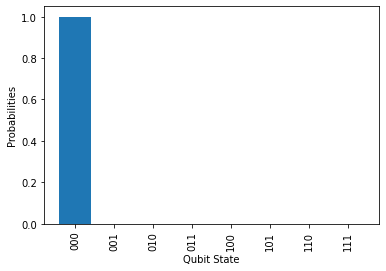

In [20]:
# 5.6 测量结果
res = cir.measure(shots=0, plot=True)

## 6. 量子门旋转角参数
&emsp;注： 
- 单量子比特门总可以由绕轴旋转表示，由旋转轴与旋转角度决定。
- 量桨中旋转轴通常设置为 $x,y,z$-轴。
- 旋转角度是量子神经网络的可变参数，**需要设置为 paddle.Tensor 形式**.

In [21]:
# 6.1 单个旋转角度

phi, theta, omega = 2 * np.pi * np.random.uniform(size=3)  # 随机旋转角度，服从均匀分布
# 变为 paddle.Tensor 形式
phi = paddle.to_tensor(phi, dtype='float64')

In [22]:
# 6.2 数组形式旋转角度
# 一维数组

theta = np.array([np.pi, 2 ,3, 5])  # 4个角度均不相同
theta = np.full([4], np.pi)  # 4个角度均等于pi
# 变为 paddle.Tensor 形式
phi = paddle.to_tensor(theta)

In [23]:
# 高维数组

theta = np.random.randn(DEPTH, N, 3)  # 一个三维 np.ndarray

对于一种常用的量子神经网络: ‘cir.complex_entangled_layer(theta, DEPTH)’，具体见[这里](https://qml.baidu.com/quick-start/quantum-neural-network.html), theta 需要为(DEPTH, N, OTHER=3)形式。

## 7. 添加量子门操作

In [24]:
# 7.1 添加单比特量子门 
# 注意旋转角度需要 paddle.Tensor 形式。
# 下标对于旋转轴，第一个参数为旋转角度，第二个参数为作用于第几个量子比特

cir.rz(theta[0], 0)

In [25]:
# 7.2 添加双量子比特门

cir.cnot([0, 1])

In [26]:
# 7.3 一些常用的量子门

# 对每一个量子比特添加 Hadamard 门
cir.superposition_layer()
# 对每一个量子比特添加 Ry(pi/4) 门
cir.weak_superposition_layer()

广义旋转门，基于欧拉角表示，以及对于量子电路具体见[这里](https://qml.baidu.com/quick-start/quantum-neural-network.html)

## 8. 变分量子算法基本框架（1）—— 构建量子电路（函数形式）
- 步骤1：构建 N 量子比特线路
- 步骤2：对每一层添加量子门

In [27]:
def circuit(N, DEPTH, theta):
    """
    输入数据:
         N,         量子比特数
         DEPTH,     电路层数
         theta,     [N, DEPTH, 2], 3维数组，数据类型：paddle.Tensor
    返回数据:
         cir,       最终量子电路
    """
    # 步骤1：构建N量子比特线路
    cir = UAnsatz(N)
    # 步骤1：对每一层添加量子门
    for dep in range(DEPTH):
        for n in range(N):
            cir.rx(theta[n][dep][0], n)  # 对第 n 个量子比特添加 Rx 门
            cir.rz(theta[n][dep][1], n)  # 对第 n 个量子比特添加 Rz 门
        for n in range(N - 1):
            cir.cnot([n, n + 1])  # 对每一对临近量子比特添加CNOT门

    return cir

In [28]:
# 以下为一个例子，包含3量子比特，两层，可调参数随机产生：
theta = paddle.to_tensor(np.random.randn(N, DEPTH, 2))
cir = circuit(N, DEPTH, theta)
print(cir)

--Rx(0.069)----Rz(0.473)----*----Rx(-0.65)----Rz(-0.77)-----------------*-------
                            |                                           |       
--Rx(-0.77)----Rz(0.623)----x--------*--------Rx(0.428)----Rz(0.074)----x----*--
                                     |                                       |  
--Rx(-0.45)----Rz(0.604)-------------x--------Rx(2.385)----Rz(-0.12)---------x--
                                                                                


## 9. 变分量子算法基本框架（2）—— 设置并计算损失函数
- 此处我们使用 “-fidelity” 作为损失函数。当输出态为我们想要的量子态时，损失函数达到最小。
- 注：量子神经网络优化在 Python 中总可以通过迭代器实现，要注意 theta 需要是 paddle.Tensor 形式

In [29]:
class StatePrepNet(paddle.nn.Layer):
    # 步骤1：给出量子神经网络初始值: def __init__(…)
    def __init__(self, N, DEPTH, psi, dtype='float64'):
        # N, DEPTH: 电路参数
        # psi: 目标量子态，数据类型：numpy行向量
        super(StatePrepNet, self).__init__()
        self.N = N
        self.DEPTH = DEPTH
        # 量子电路可调参数初始化随机产生
        self.theta = self.create_parameter(shape=[self.N, self.DEPTH, 2],
              default_initializer=paddle.nn.initializer.Uniform(low=0., high=2 * np.pi), 
              dtype=dtype, is_bias=False)
        # 目标量子态，用于计算损失函数(需要 paddle.Tensor 类型)
        self.psi = paddle.to_tensor(psi)
    # 步骤2：计算损失函数L = - <psi_out | psi><psi | psi_out>
    # 注：由于需要最小化损失函数，取“-fidelity”
    def forward(self):
        # 构建量子电路，参数随迭代改变
        cir = circuit(self.N, self.DEPTH, self.theta)
        # 得到此量子电路输出量子态
        psi_out = cir.run_state_vector()
        psi_out = paddle.reshape(psi_out, [2 ** self.N, 1])  # reshape to ket
        # 计算损失函数: L = - <psi_out | psi><psi | psi_out>
        inner = matmul(self.psi, psi_out)
        loss = - paddle.real(matmul(inner, dagger(inner)))[0]  # 改变shape为tensor([1])
        
        return loss, cir

## 10. 变分量子算法基本框架（3）—— 通过优化器优化参数
- 此处我们对制备3量子比特 $|01\rangle\otimes|+\rangle$ 为例，使用的量子电路有上述 “8. 量子神经网络算法基本框架” 部分给出。
- 通常我们选 Adam 为优化器。
- 首先我们给出一些训练用的参数。

In [30]:
N = 3      # 目标量子比特数
DEPTH = 2  # 量子电路层数
ITR = 115  # 学习迭代次数
LR = 0.2   # 学习速率

In [31]:
# 目标量子态，取 numpy 行向量形式
psi_target = np.kron(np.kron(np.array([[1,0]]), np.array([[0,1]])), np.array([[1/np.sqrt(2), 1/np.sqrt(2)]]))  # <01+|

In [32]:
# 10.1 记录迭代中间过程
loss_list = []
parameter_list = []

In [33]:
# 10.2 构造迭代器
# (N=3, DEPTH=2, ITR=110, LR=0.2)
myLayer = StatePrepNet(N, DEPTH, psi_target)

In [34]:
# 10.3 选择优化器
# 通常使用 Adam。
opt = paddle.optimizer.Adam(learning_rate = LR, parameters = myLayer.parameters())    

In [35]:
# 10.4 迭代优化
for itr in range(ITR):
    # 计算损失函数
    loss = myLayer()[0]
    # 通过梯度下降算法优化
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    # 记录学习曲线
    loss_list.append(loss.numpy()[0])
    parameter_list.append(myLayer.parameters()[0].numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())

iter: 0   loss: -0.0176
iter: 10   loss: -0.8356
iter: 20   loss: -0.9503
iter: 30   loss: -0.9837
iter: 40   loss: -0.9971
iter: 50   loss: -0.9974
iter: 60   loss: -0.9995
iter: 70   loss: -0.9999
iter: 80   loss: -0.9999
iter: 90   loss: -1.0000
iter: 100   loss: -1.0000
iter: 110   loss: -1.0000


In [36]:
# 10.5 输出结果

# 输出最终损失函数值
print('The minimum of the loss function: ', loss_list[-1])
# 输出最终量子电路参数
theta_final = parameter_list[-1]  # 得到self.theta
print("Parameters after optimizationL theta:\n", theta_final)
# 绘制最终电路与输出量子态
# 输入量子电路参数需要转化为 paddle.Tensor 类型
theta_final = paddle.to_tensor(theta_final)
# 绘制电路
cir_final = circuit(N, DEPTH, theta_final)
print(cir_final)
# 最终得到量子态
#state_final = cir_final.run_density_matrix()
state_final = cir_final.run_state_vector()
print("state_final:\n", state_final.numpy())

The minimum of the loss function:  -0.9999873168488457
Parameters after optimizationL theta:
 [[[-0.00816927  7.41571003]
  [ 6.28197865  0.29031951]]

 [[ 3.14801248  6.1562368 ]
  [ 6.2890315   4.08082862]]

 [[ 4.57489065  1.58064113]
  [ 4.78145659  3.28051687]]]
--Rx(-0.00)----Rz(7.416)----*----Rx(6.282)----Rz(0.290)-----------------*-------
                            |                                           |       
--Rx(3.148)----Rz(6.156)----x--------*--------Rx(6.289)----Rz(4.081)----x----*--
                                     |                                       |  
--Rx(4.575)----Rz(1.581)-------------x--------Rx(4.781)----Rz(3.281)---------x--
                                                                                
state_final:
 [-0.0001236 +1.65203739e-04j -0.00051346-3.22614883e-04j
  0.09637039-7.00598643e-01j  0.09558872-7.00513830e-01j
  0.00038931+1.78566178e-04j  0.0003892 +1.76713800e-04j
  0.00209719+1.98540264e-03j  0.0025603 +1.33735551e-03j]


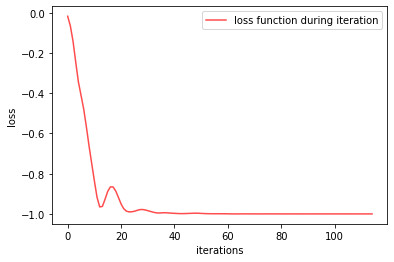

In [37]:
# 绘制迭代过程中损失函数变化曲线
plt.figure(1)
ITR_list = []
for i in range(ITR):
    ITR_list.append(i)
func = plt.plot(ITR_list, loss_list, alpha=0.7, marker='', linestyle='-', color='r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(labels=["loss function during iteration"], loc='best')
plt.show()

**可见，最终 “-fidelity” 变为 “-1”, 此时量子电路已学会如何制备目标量子态 “$|01\rangle\otimes|+\rangle$”。**